In [1]:
%%html
<style> table { display: inline-block } </style>

# CAB420 Assigment 2 - Model 3 - Addon

| Name   | Student Number |
| :---   | :--- |
| Charmi Raval       | N10510702          |
| Leonardo Villamil  | N10411526          |
| Litian Chen        | N9646922           |
| Tace Stewart       | N9654411           |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import visualkeras

from sklearn.utils import class_weight
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50

## Load Data

In [3]:
# Load data
train = pd.read_csv ('Data/training.csv')
validation = pd.read_csv ('Data/validation.csv')
test = pd.read_csv ('Data/testing.csv')

In [4]:
# Split filename, features and label

X_train = train.drop(['filename', 'accent'], axis=1)
path_train = train['filename'].to_numpy()
y_train = train['accent'].to_numpy()

X_val = validation.drop(['filename', 'accent'], axis=1)
path_val = validation['filename'].to_numpy()
y_val = validation['accent'].to_numpy()

X_test = test.drop(['filename', 'accent'], axis=1)
path_test = test['filename'].to_numpy()
y_test = test['accent'].to_numpy()

In [5]:
# Encode strings into class numbers
labels = np.unique(y_train)

encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [6]:
# Calculation of class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

for i in range(17):
    print('%s - class %s - weight %s\n' %(labels[i], (str(np.unique(y_train)[i])), str(class_weights[i])))

african - class 0 - weight 3.7325975166185876

australia - class 1 - weight 0.9309988842195273

bermuda - class 2 - weight 29.67098703888335

canada - class 3 - weight 1.010343344725347

england - class 4 - weight 0.31900411260902345

hongkong - class 5 - weight 13.43162328870167

indian - class 6 - weight 0.7413558308698973

ireland - class 7 - weight 5.088919288645691

malaysia - class 8 - weight 15.962810656177364

newzealand - class 9 - weight 4.769995191537105

other - class 10 - weight 1.1126620139581256

philippines - class 11 - weight 12.156862745098039

scotland - class 12 - weight 4.539122476994255

singapore - class 13 - weight 35.48489666136725

southatlandtic - class 14 - weight 71.941982272361

us - class 15 - weight 0.12046160758497954

wales - class 16 - weight 15.914438502673796



E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], y=[15  4 15 ... 15  3  6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [7]:
datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory(r'E:\OneDrive - Queensland University of Technology\MoProfEng\SEM-1\CAB420\Assignment2\spectograms\train',
                                       target_size=(224, 224),
                                       classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],
                                       class_mode='categorical', batch_size=64, seed=1)

# load and iterate validation dataset
val_it = datagen.flow_from_directory(r'E:\OneDrive - Queensland University of Technology\MoProfEng\SEM-1\CAB420\Assignment2\spectograms\validation',
                                     target_size=(224, 224),
                                     classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'], 
                                     class_mode='categorical', batch_size=64, seed=1)

# load and iterate test dataset
test_it = datagen.flow_from_directory(r'E:\OneDrive - Queensland University of Technology\MoProfEng\SEM-1\CAB420\Assignment2\spectograms\test',
                                      target_size=(224, 224),
                                      classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],
                                      class_mode='categorical', batch_size=1,
                                      shuffle=False)

Found 89280 images belonging to 17 classes.
Found 29759 images belonging to 17 classes.
Found 29759 images belonging to 17 classes.


## Fine-tuning 

In [8]:
def eval_model(prediction, test_it, labels, history):
    test_it.reset()
    print('Classification Report\n')
    print(classification_report(test_it.classes, prediction))

    test_it.reset()
    print('Confusion Matrix')
    cm = confusion_matrix(test_it.classes, prediction, normalize='true')
    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=labels)
    c.plot(ax = ax);

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['precision'], label="Training Precision")
    ax.plot(history.history['val_precision'], label="Validation Precision")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['recall'], label="Training Recall")
    ax.plot(history.history['val_recall'], label="Validation Recall")
    ax.legend();

In [9]:
ResNet = ResNet50()
print(ResNet.summary())
plot_model(ResNet, show_shapes=True)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

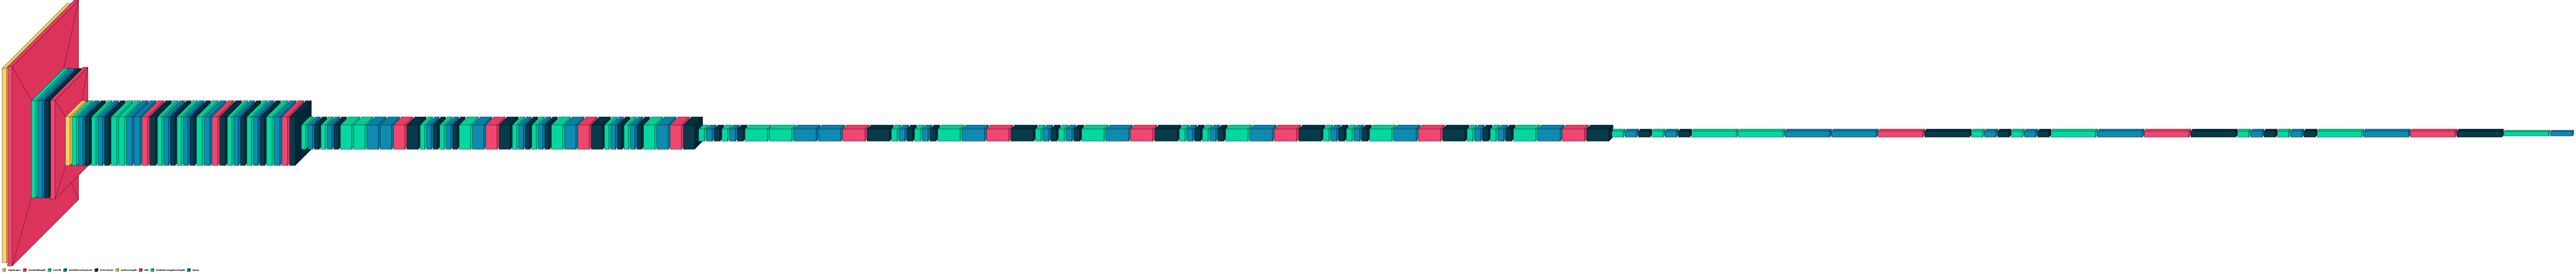

In [10]:
visualkeras.layered_view(ResNet, legend=True)

In [11]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
print(baseModel.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(17, activation="softmax")(headModel)

cnn_model3_add = Model(inputs=baseModel.input, outputs=headModel, name='cnn_model3_add')
print(cnn_model3_litian.summary())

Model: "cnn_model3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________________________

In [13]:
# Freeze the base model layers
for layer in baseModel.layers:
	layer.trainable = False

In [14]:
cnn_model3_add.compile(optimizer=keras.optimizers.Adam(),
                   loss='categorical_crossentropy',
                   loss_weights=class_weights,
                   metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

In [15]:
load = False

if load:
    cnn_model3_add = load_model('Models/cnn_model3_add')
else:
    history = cnn_model3_add.fit(train_it,
                            steps_per_epoch=1395,
                            epochs=25,
                            validation_data=val_it,
                            validation_steps=465)

    # Save model
    cnn_model3_add.save('Models/cnn_model3_add')

Epoch 1/25
1395/1395 [==============================] - 4194s 3s/step - loss: 22.8919 - accuracy: 0.4769 - precision: 0.5058 - recall: 0.1921 - val_loss: 20.9465 - val_accuracy: 0.4884 - val_precision: 0.6165 - val_recall: 0.0977
Epoch 2/25
1395/1395 [==============================] - 4062s 3s/step - loss: 21.4370 - accuracy: 0.4927 - precision: 0.5405 - recall: 0.2052 - val_loss: 20.6246 - val_accuracy: 0.4918 - val_precision: 0.5965 - val_recall: 0.2350
Epoch 3/25
1395/1395 [==============================] - 4301s 3s/step - loss: 21.0829 - accuracy: 0.4979 - precision: 0.5604 - recall: 0.2241 - val_loss: 20.4606 - val_accuracy: 0.4993 - val_precision: 0.6346 - val_recall: 0.1406
Epoch 4/25
1395/1395 [==============================] - 4371s 3s/step - loss: 20.9253 - accuracy: 0.4966 - precision: 0.5623 - recall: 0.2247 - val_loss: 20.3947 - val_accuracy: 0.4981 - val_precision: 0.5426 - val_recall: 0.4095
Epoch 5/25
1395/1395 [==============================] - 4184s 3s/step - loss: 20

29759/29759 [==============================] - 1706s 57ms/step - loss: 19.2932 - accuracy: 0.5312 - precision: 0.6140 - recall: 0.3353
Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.82      0.07      0.13      1817
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00      1682
           4       0.49      0.10      0.17      5455
           5       0.00      0.00      0.00       133
           6       0.79      0.19      0.31      2323
           7       0.00      0.00      0.00       357
           8       0.00      0.00      0.00        97
           9       0.00      0.00      0.00       384
          10       0.77      0.28      0.42      1632
          11       0.00      0.00      0.00       135
          12       0.00      0.00      0.00       386
          13       0.00      0.00      0.00        67
          14       0.00      0.

E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


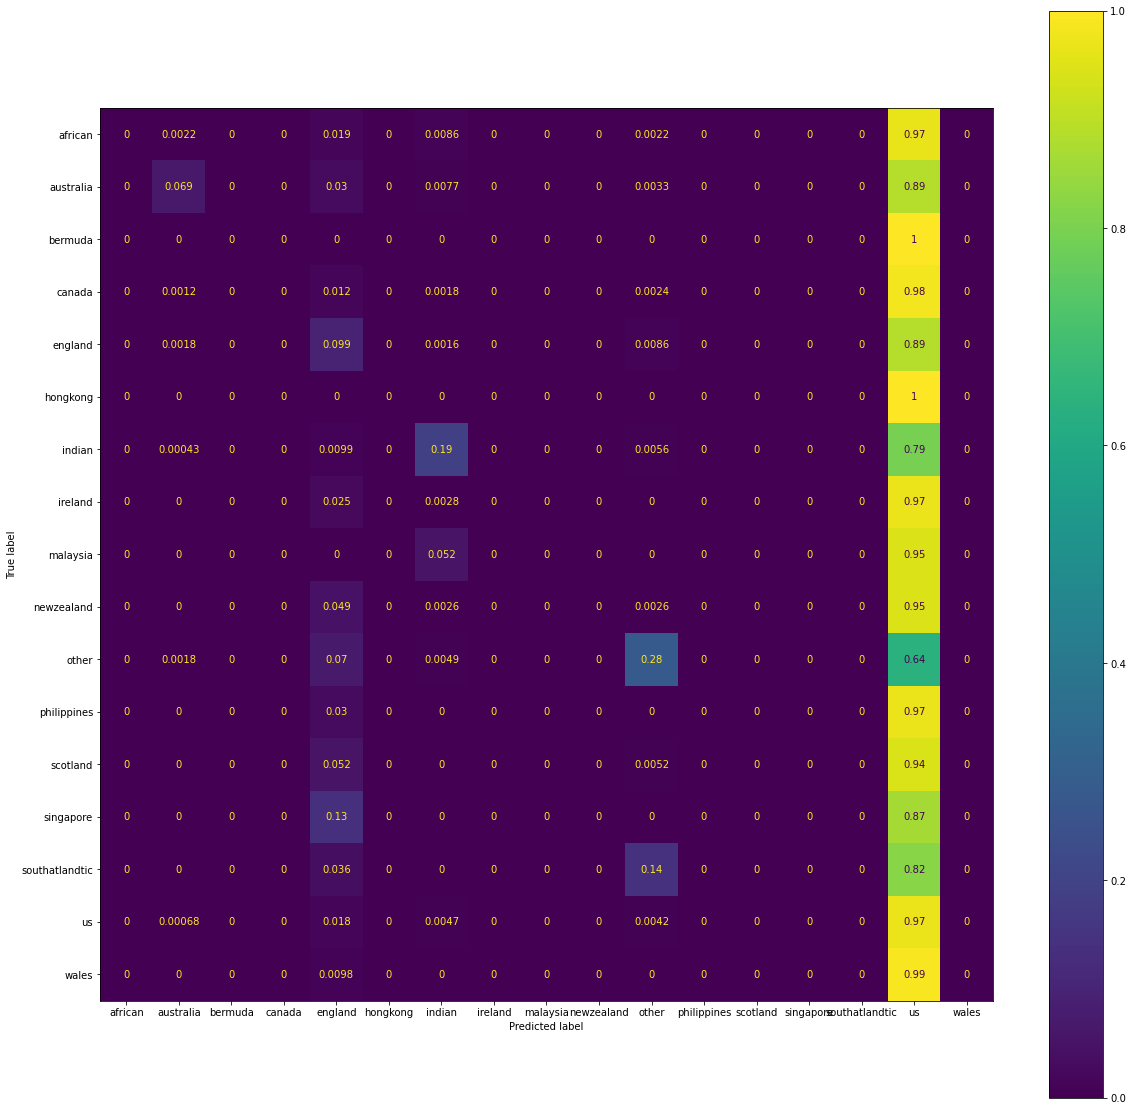

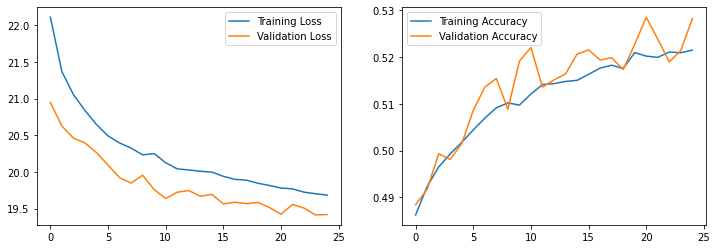

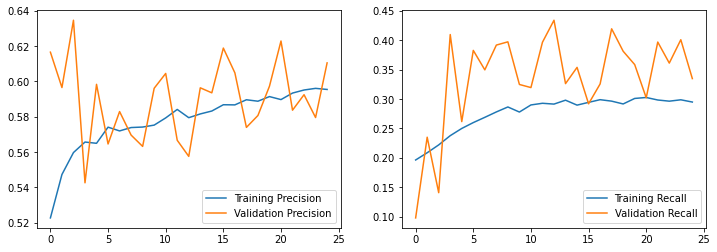

In [16]:
test_it.reset()
test_scores = cnn_model3_add.evaluate(test_it, steps=29759)

test_it.reset()
prediction = cnn_model3_add.predict(test_it, steps=29759)
prediction = np.argmax(prediction, axis=1)

eval_model(prediction, test_it, labels, history)